In [1]:
%matplotlib inline
import os, sys
project_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.insert(0, project_dir)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from plotting import plot_confusion_matrix
from sklearn import metrics
seed = 42
np.random.seed(seed)

from keras.layers import Dropout
from keras.utils import np_utils

Using Theano backend.
Using cuDNN version 5105 on context None
Mapped name None to device cuda: GRID K520 (0000:00:03.0)


### Import MNIST dataset

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

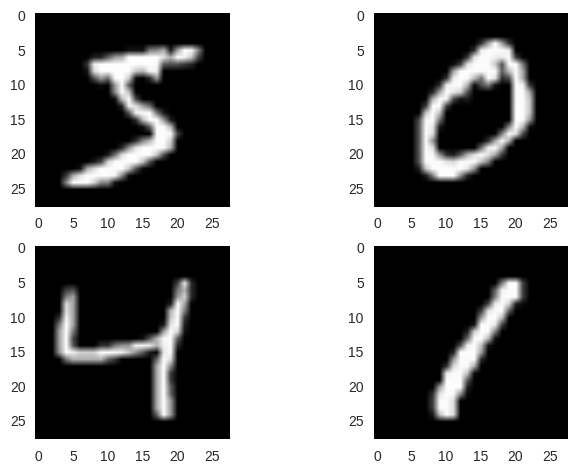

In [3]:
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.grid(0)
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.grid(0)
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.grid(0)
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
plt.grid(0)

### Fully connected baseline model

In [4]:
from keras.models import Sequential
from keras.layers import Dense

#### Preprocessing

In [5]:
img_rows, img_cols = 28, 28
nb_classes = 10

In [6]:
num_pixels = img_rows * img_cols
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test  =  X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [7]:
# normalize input values: 0-255 to 0-1
X_train = X_train/255
X_test = X_test/255

In [8]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [9]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [10]:
print(y_test[0])
print(y_test[1])

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


#### create model

<img src="files/fully_connected.png">

In [11]:
# create model
b_model = Sequential()

# input layer
b_model.add(Dense(num_pixels, input_dim=num_pixels, init='normal', activation='relu'))

# hidden layer
b_model.add(Dense(500, init='normal', activation='relu'))

# output layer
b_model.add(Dense(nb_classes, init='normal', activation='softmax'))

# Compile model
b_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

b_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 784)           615440      dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 500)           392500      dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 10)            5010        dense_2[0][0]                    
Total params: 1,012,950
Trainable params: 1,012,950
Non-trainable params: 0
____________________________________________________________________________________________________


#### Train classifier

In [12]:
b_history = b_model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=64, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
5s - loss: 0.1836 - acc: 0.9437 - val_loss: 0.0918 - val_acc: 0.9715
Epoch 2/10
3s - loss: 0.0725 - acc: 0.9771 - val_loss: 0.0793 - val_acc: 0.9748
Epoch 3/10
3s - loss: 0.0479 - acc: 0.9841 - val_loss: 0.0789 - val_acc: 0.9768
Epoch 4/10
3s - loss: 0.0354 - acc: 0.9884 - val_loss: 0.0682 - val_acc: 0.9793
Epoch 5/10
3s - loss: 0.0285 - acc: 0.9906 - val_loss: 0.0942 - val_acc: 0.9761
Epoch 6/10
3s - loss: 0.0239 - acc: 0.9921 - val_loss: 0.0717 - val_acc: 0.9822
Epoch 7/10
3s - loss: 0.0189 - acc: 0.9941 - val_loss: 0.0760 - val_acc: 0.9796
Epoch 8/10
3s - loss: 0.0197 - acc: 0.9934 - val_loss: 0.0856 - val_acc: 0.9803
Epoch 9/10
3s - loss: 0.0148 - acc: 0.9954 - val_loss: 0.0828 - val_acc: 0.9797
Epoch 10/10
3s - loss: 0.0169 - acc: 0.9948 - val_loss: 0.0915 - val_acc: 0.9798


In [13]:
score = b_model.evaluate(X_test, y_test, verbose=0)
# print('Test loss: \t', score[0])
print('Test accuracy:\t', score[1])

Test accuracy:	 0.9798


In [14]:
predictions_raw = b_model.predict(X_test)
predictions = [np.argmax(x) for x in predictions_raw]

y_true = [np.argmax(x) for x in y_test]

Confusion matrix, without normalization


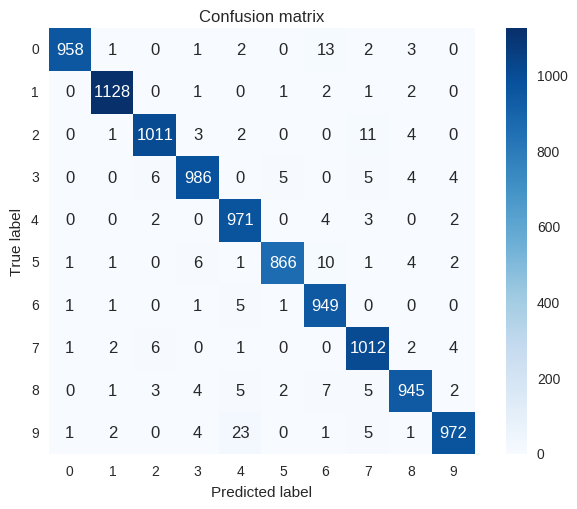

In [15]:
plot_confusion_matrix(metrics.confusion_matrix(y_true, predictions), np.unique(y_true))

#### Convolutional Network

In [16]:
from keras.layers import Flatten
from keras.layers.core import Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape to be [samples][pixels (colors)][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

<img src="files/convnet_fig.png">

In [17]:
# number of convolutional filters to use
nb_filters = 32

# size of pooling area for max pooling
pool_size = (2, 2)

# convolution kernel size
kernel_size = (3, 3)

input_shape = (1, img_rows, img_cols)

In [18]:
#create model
model = Sequential()

# convolution layer
model.add(Convolution2D(nb_filters, 
                        kernel_size[0], 
                        kernel_size[1], 
                        input_shape=input_shape))
convout1 = Activation('relu')
model.add(convout1)

# max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten & fully connected
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# output layer
model.add(Dense(nb_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 26, 26)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 26, 26)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 13, 13)    0           activation_1[0][0]               
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 5408)          0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [20]:
conv_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=64, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
3s - loss: 0.1744 - acc: 0.9483 - val_loss: 0.0648 - val_acc: 0.9808
Epoch 2/10
3s - loss: 0.0575 - acc: 0.9829 - val_loss: 0.0482 - val_acc: 0.9832
Epoch 3/10
3s - loss: 0.0376 - acc: 0.9882 - val_loss: 0.0464 - val_acc: 0.9848
Epoch 4/10
3s - loss: 0.0264 - acc: 0.9921 - val_loss: 0.0493 - val_acc: 0.9851
Epoch 5/10
3s - loss: 0.0175 - acc: 0.9949 - val_loss: 0.0429 - val_acc: 0.9855
Epoch 6/10
3s - loss: 0.0136 - acc: 0.9957 - val_loss: 0.0490 - val_acc: 0.9846
Epoch 7/10
3s - loss: 0.0095 - acc: 0.9971 - val_loss: 0.0444 - val_acc: 0.9866
Epoch 8/10
3s - loss: 0.0079 - acc: 0.9976 - val_loss: 0.0451 - val_acc: 0.9877
Epoch 9/10
3s - loss: 0.0075 - acc: 0.9977 - val_loss: 0.0487 - val_acc: 0.9855
Epoch 10/10
3s - loss: 0.0039 - acc: 0.9989 - val_loss: 0.0523 - val_acc: 0.9860


In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:\t', score[1])

Test accuracy:	 0.986


In [22]:
predictions_raw_conv = model.predict(X_test)
predictions_conv = [np.argmax(x) for x in predictions_raw_conv]
    
y_true = [np.argmax(x) for x in y_test]

Confusion matrix, without normalization


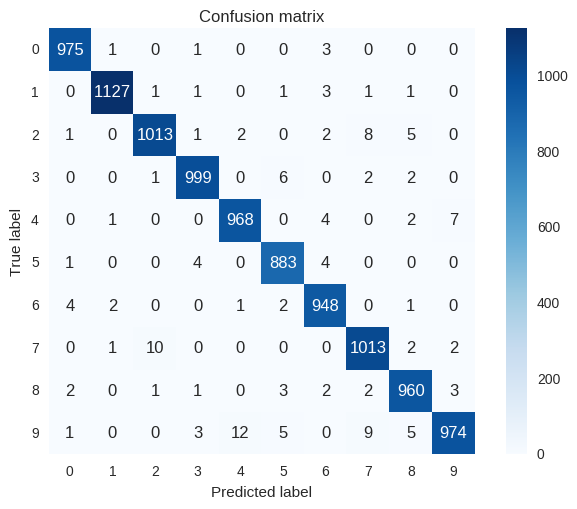

In [23]:
plot_confusion_matrix(metrics.confusion_matrix(y_true, predictions_conv), np.unique(y_true))

### Visualize convolutions

In [24]:
from keras import backend as K

In [25]:
inputs = [K.learning_phase()] + model.inputs

_convout1_f = K.function(inputs, [convout1.output])
def convout1_f(X):
    # The [0] is to disable the training phase flag
    return _convout1_f([0] + [X])

In [26]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)
    plt.grid(0)
    ax.grid(0)

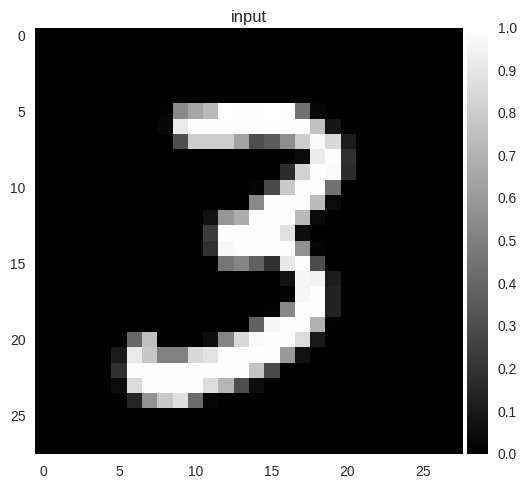

In [27]:
# i = 4100
i = 4600

# Visualize the first layer of convolutions on an input image
X = X_test[i:i+1]

plt.figure()
plt.title('input')
nice_imshow(plt.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.gray)
plt.grid(0)

In [28]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

#plt.imshow(make_mosaic(np.random.random((9, 10, 10)), 3, 3, border=1))

### visualize weights

W shape :  (32, 3, 3)


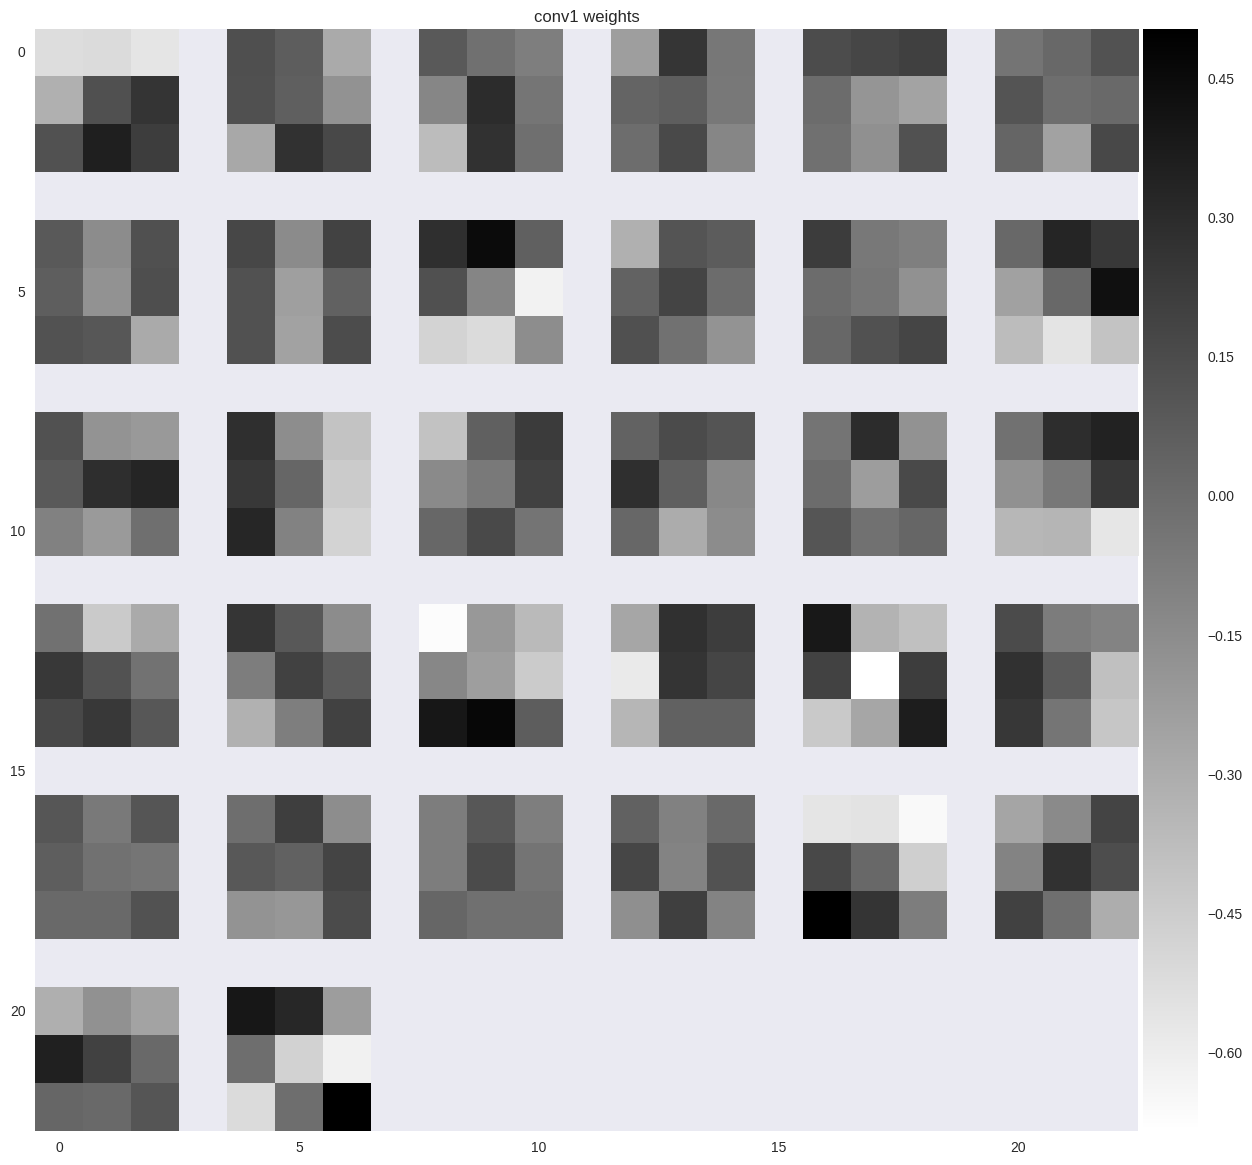

In [29]:
# Visualize weights
W = model.layers[0].W.get_value(borrow=True)
W = np.squeeze(W)
print("W shape : ", W.shape)

plt.figure(figsize=(15, 15))
plt.title('conv1 weights')
nice_imshow(plt.gca(), make_mosaic(W, 6, 6), cmap=cm.binary)

C1 shape :  (32, 26, 26)


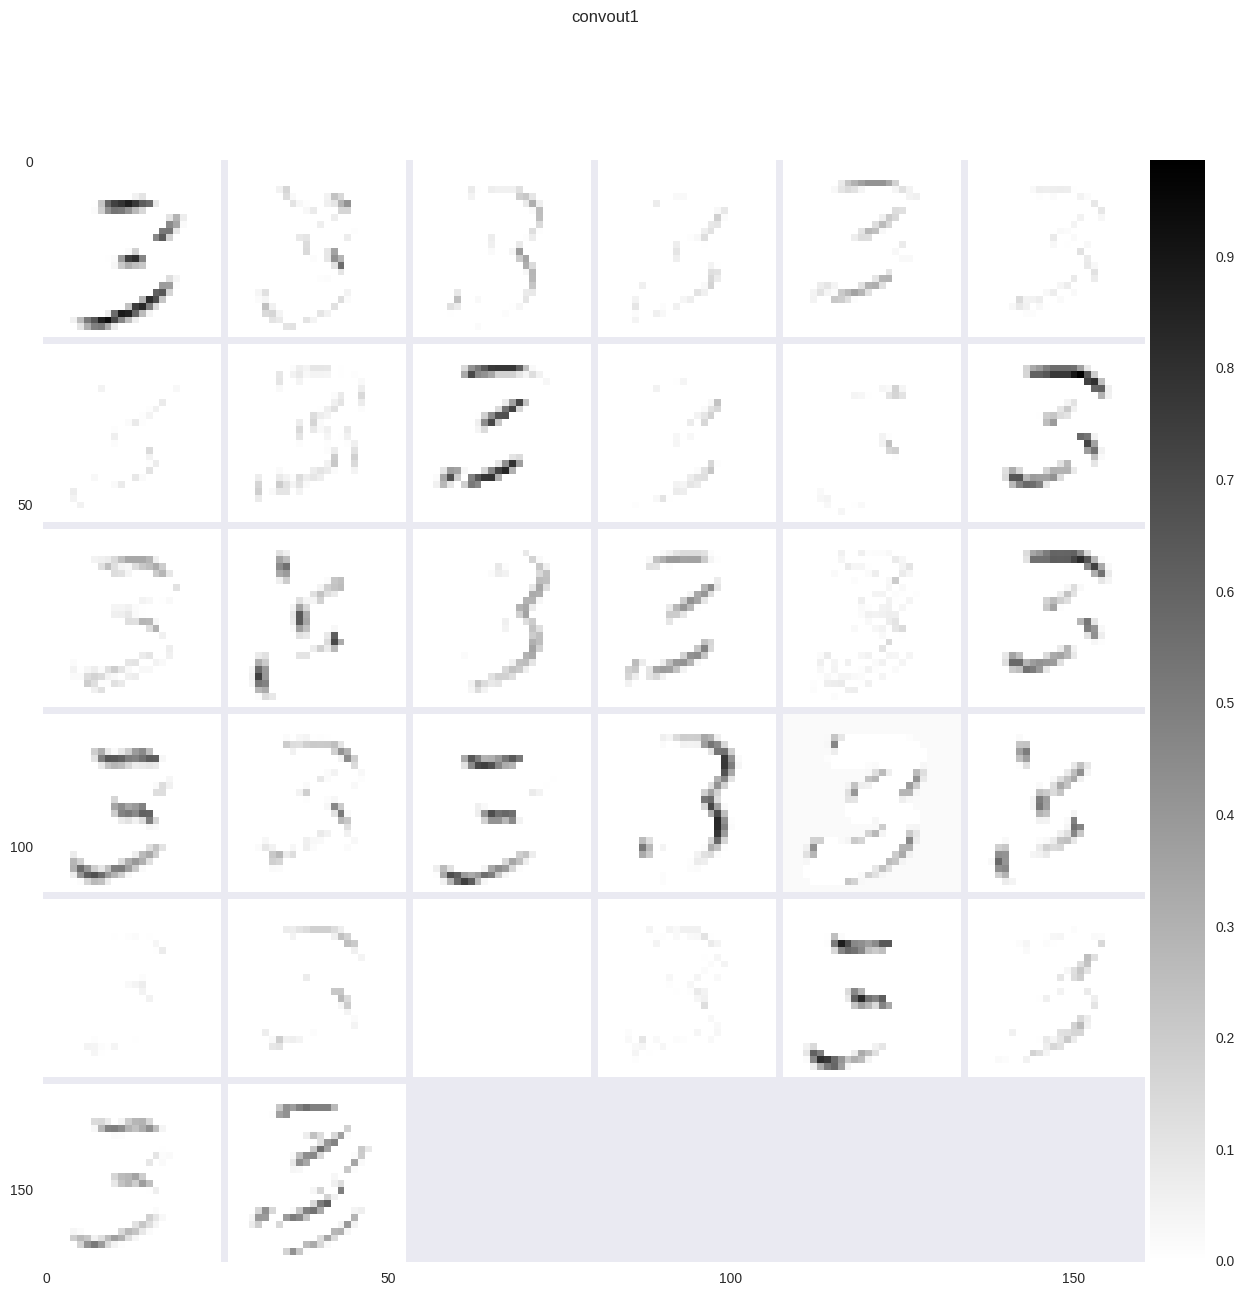

In [30]:
# Visualize convolution result (after activation)
C1 = convout1_f(X)
C1 = np.squeeze(C1)
print("C1 shape : ", C1.shape)

plt.figure(figsize=(15, 15))
plt.suptitle('convout1')
nice_imshow(plt.gca(), make_mosaic(C1, 6, 6), cmap=cm.binary)

In [31]:
from keras.utils.visualize_util import plot
plot(model, to_file='model.png', show_shapes=True)